In [654]:
import yfinance as yf
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from datetime import datetime, timedelta
import statsmodels.api as sm
import pandas_ta as ta

from performance_indicator import *
from trading_computation import *
from plotting_computation import *

In [655]:
LEVERAGE = 10
MAX_LEVERAGE = 10
INITIAL_CAP = 200000
TRAINSIZE = 0.7
INCREASE_RF = False # Explore the situation when effr increase 150%

## 1. Time Series Prep

- The adjusted closing price amends a stock's closing price to reflect that stock's value after accounting for any corporate actions. It is often used when examining historical returns or doing a detailed analysis of past performance.

In [656]:
end_date = datetime(2019, 12, 31)
start_date = datetime(2014, 1, 1)

# Download data as dataframe
ETF = yf.download('SPTL', start=start_date, end=end_date).reset_index()
EFFR = web.DataReader('EFFR', 'fred', start_date, end_date).dropna().reset_index().rename({'DATE':'Date'}, axis = 1)

[*********************100%***********************]  1 of 1 completed


In [657]:
# The EFFR data will be Nan at weekends or some other federal holidays
# The weekends are not tradings days and hence they are dropped. Otherwise, use forward fill method
# Assuing the EFFR data to the same as the previous day
df = pd.merge(left = ETF, right = EFFR, on = 'Date', how = 'left').ffill(axis = 0)
df = df[['Date', 'Close', 'EFFR']]
df['EFFR'] = pd.to_numeric(df['EFFR'], errors='coerce')
# Adjust the annual risk-free rate to make it a daily rate
if INCREASE_RF:
    df['Daily_EFFR'] = df['EFFR']/(252*100) * 1.5
else:
    df['Daily_EFFR'] = df['EFFR']/(252*100)
# Calculate the daily execess return per unit SPTL
df['Daily_return'] = df['Close'].pct_change(1, fill_method='ffill')
df['Daily_excess_return'] = df['Close'].pct_change(1, fill_method='ffill') - df['Daily_EFFR']

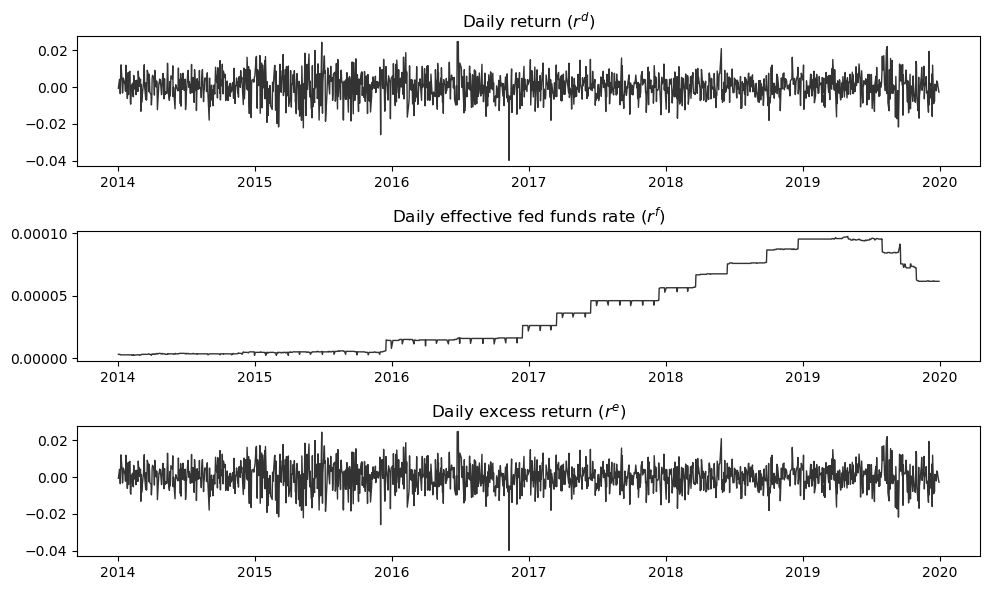

In [658]:
fig, ax = plt.subplots(3, 1, figsize = (10, 6))

ax[0].plot(df['Date'], df['Daily_return'], color = 'black', lw = 1, alpha = 0.8)
ax[0].set_title(r'Daily return ($r^d$)')
ax[1].plot(df['Date'], df['Daily_EFFR'], color = 'black', lw = 1, alpha = 0.8)
ax[1].set_title(r'Daily effective fed funds rate ($r^f$)')
ax[2].plot(df['Date'], df['Daily_excess_return'], color = 'black', lw = 1, alpha = 0.8)
ax[2].set_title(r'Daily excess return ($r^e$)')
plt.tight_layout()

## 2. Trading Strategies

### Strategy: MACD Strategy

In [659]:
df['ema12'] = df['Close'].ewm(span = 12).mean()
df['ema26'] = df['Close'].ewm(span = 26).mean()
df['macd'] = df['ema12'] - df['ema26']
df['macd_signal'] = df['macd'].ewm(span = 9).mean()
df['macd_hist'] = df['macd'] - df['macd_signal']

train_size = int(len(df) * TRAINSIZE)
train_set = df[:train_size]
test_set = df[train_size:]

In [660]:
train_set

,Date,Close,EFFR,Daily_EFFR,Daily_return,Daily_excess_return,ema12,ema26,macd,macd_signal,macd_hist
0,2014-01-02,30.055000,0.08,0.000003,NaN,NaN,30.055000,30.055000,0.000000,0.000000,0.000000
1,2014-01-03,30.035000,0.08,0.000003,-0.000665,-0.000669,30.044167,30.044615,-0.000449,-0.000249,-0.000199
2,2014-01-06,30.160000,0.08,0.000003,0.004162,0.004159,30.089376,30.086072,0.003304,0.001207,0.002097
3,2014-01-07,30.260000,0.07,0.000003,0.003316,0.003313,30.143236,30.134695,0.008541,0.003692,0.004849
4,2014-01-08,30.150000,0.07,0.000003,-0.003635,-0.003638,30.145073,30.138244,0.006829,0.004625,0.002204
...,...,...,...,...,...,...,...,...,...,...,...
1051,2018-03-07,34.009998,1.42,0.000056,-0.000588,-0.000644,34.093044,34.356727,-0.263683,-0.331539,0.067855
1052,2018-03-08,34.200001,1.42,0.000056,0.005587,0.005530,34.109499,34.345118,-0.235619,-0.312355,0.076736
1053,2018-03-09,33.990002,1.42,0.000056,-0.006140,-0.006197,34.091115,34.318813,-0.227698,-0.295423,0.067725
1054,2018-03-12,34.200001,1.42,0.000056,0.006178,0.006122,34.107866,34.310012,-0.202146,-0.276768,0.074622


<BarContainer object of 1509 artists>

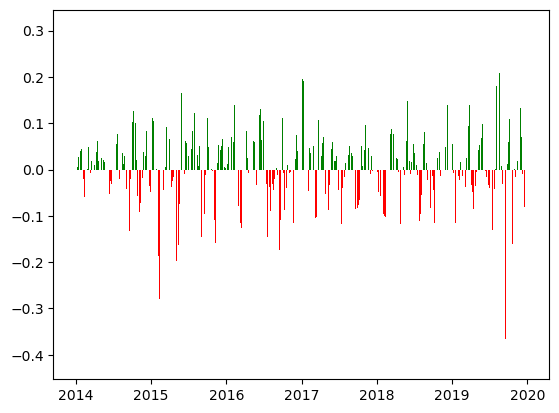

In [661]:
color = np.where(df['macd_hist'] >= 0, 'green', 'red')
plt.bar(df['Date'], df['macd_hist'], color = color)

In [662]:
# Trading signal
regime = [0]
macd_hist = np.array(df['macd_hist'])
for i in range(1, len(macd_hist)):
    if macd_hist[i] >= 0 and macd_hist[i-1] < 0:
        regime.append(1)
    elif macd_hist[i] <= 0 and macd_hist[i-1] > 0:
        regime.append(-1)
    else:
        regime.append(0)
        
regime_train = regime[:train_size]
regime_test = regime[train_size:]

/Users/chenkangan/Documents/UCL DSML/Algorithmic Trading/CW2/plotting_computation.py:84: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/Users/chenkangan/Documents/UCL DSML/Algorithmic Trading/CW2/plotting_computation.py:163: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


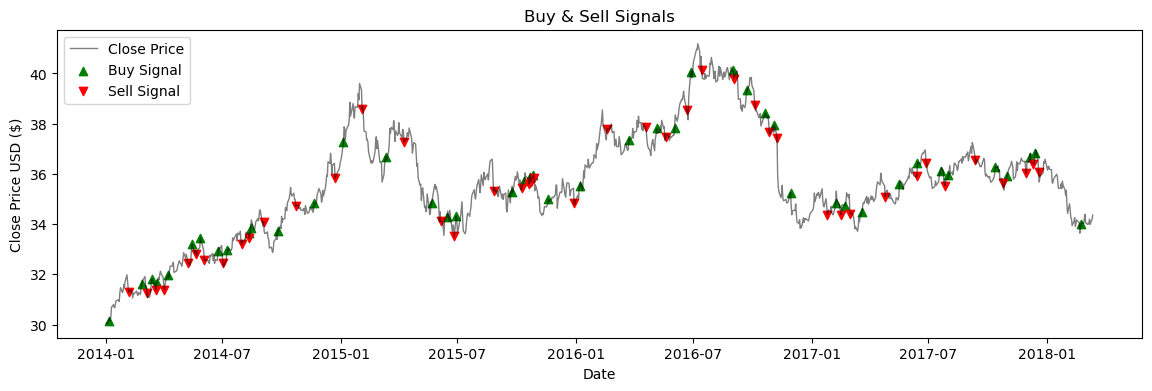

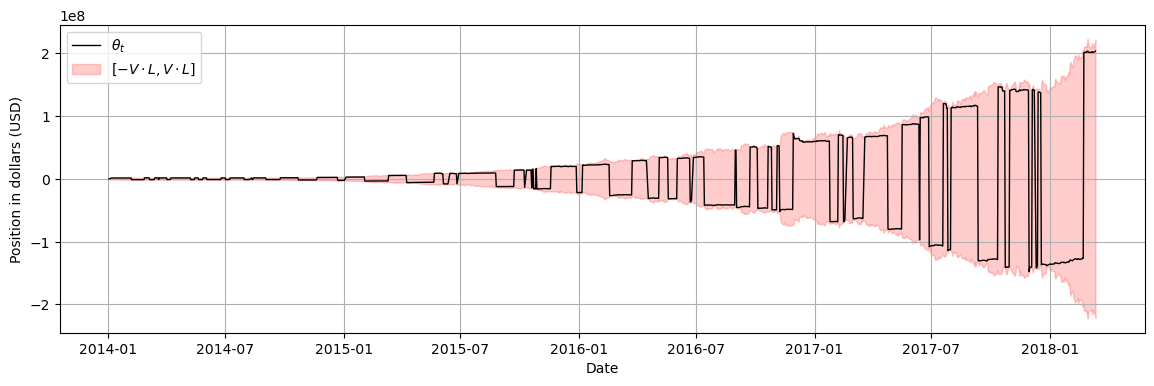

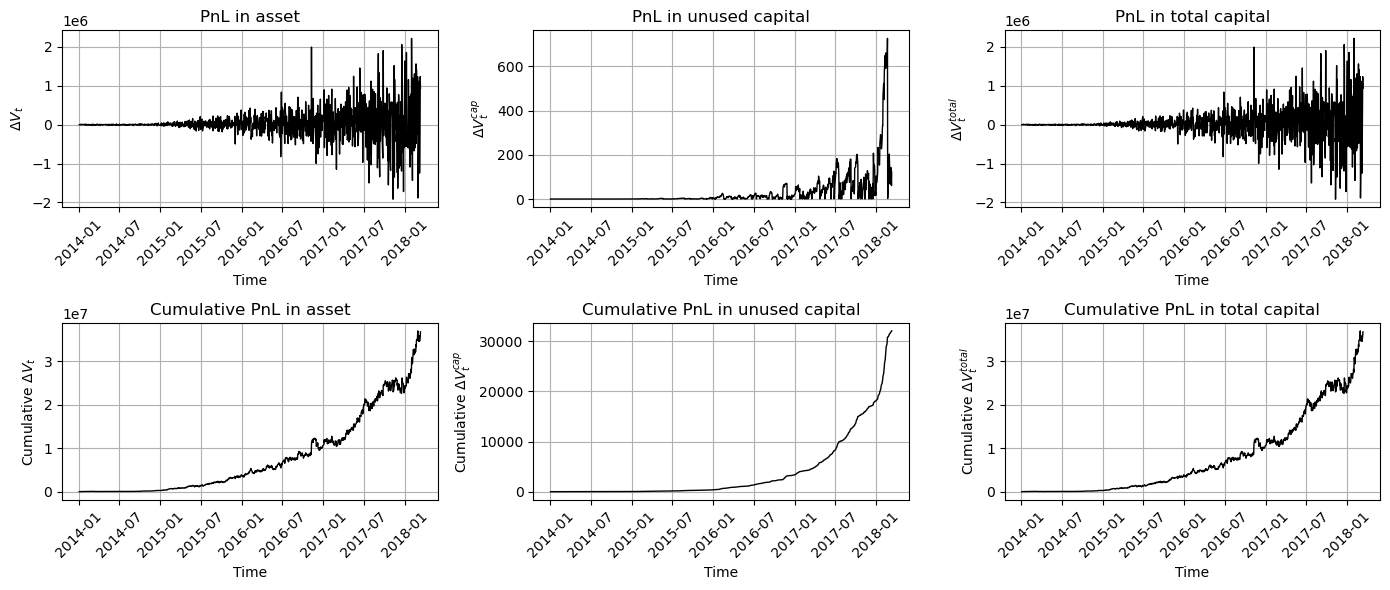

In [663]:
result_train = compute_position_value(df = train_set, 
                           signal = regime_train, 
                           initial_capital = INITIAL_CAP, 
                           max_leverage = LEVERAGE, 
                           reduced_leverage_shorting = False,
                           hold_at_signal_0 = True)

plot_strategy(df = train_set, 
              result_dict = result_train, 
              signal = regime_train, 
              leverage = MAX_LEVERAGE)

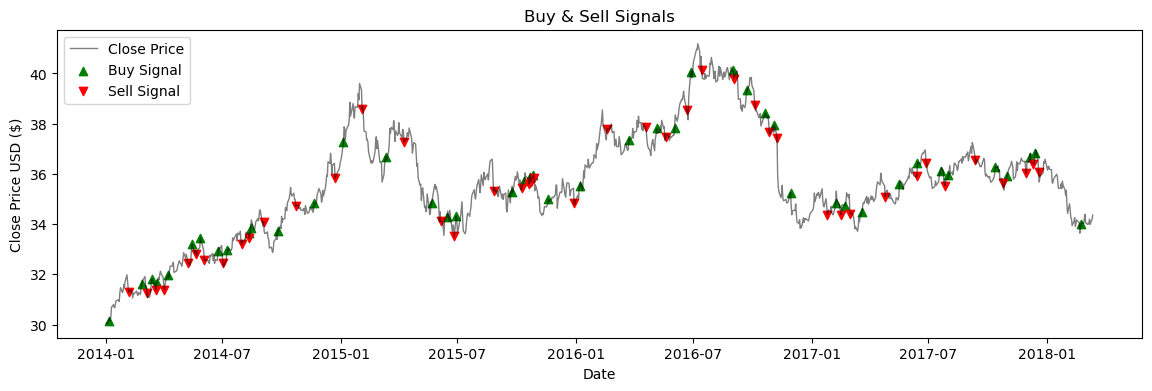

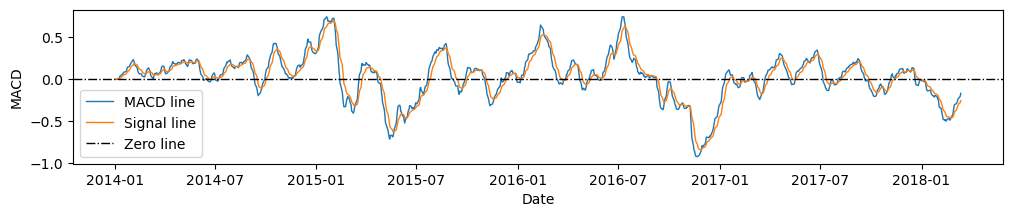

In [664]:

plot_signals(strategy_data=train_set, signal = regime_train)
fig, ax = plt.subplots(1, 1, figsize = (12, 2))
ax.set_xlabel('Date')
ax.set_ylabel('MACD')

buy_macd = np.array(train_set['macd'])[np.where(regime_train == 1)]
buy_macd_time = np.array(train_set['Date'])[np.where(regime_train == 1)]
sell_macd = np.array(train_set['macd'])[np.where(regime_train == -1)]
sell_macd_time = np.array(train_set['Date'])[np.where(regime_train == -1)]

ax.plot(train_set['Date'], train_set['macd'], lw = 1, label = 'MACD line')
ax.plot(train_set['Date'], train_set['macd_signal'], lw = 1, label = 'Signal line')
ax.axhline(y = 0, color = 'black', lw = 1, ls = '-.', label = 'Zero line')
# plt.scatter(buy_macd_time, buy_macd, label='Buy Signal', marker='^', alpha=1, color='green')
# plt.scatter(sell_macd_time, sell_macd, label='Sell Signal', marker='v', alpha=1, color='red')

color = np.where(train_set['macd_hist'] >= 0, 'green', 'red')

# plt.plot(df['Date'], df['macd'], label = 'MACD')
# plt.plot(df['Date'], df['macd_signal'], label = 'Signal')
# ax.bar(train_set['Date'], train_set['macd_hist'], color = color)
ax.legend(loc='lower left')


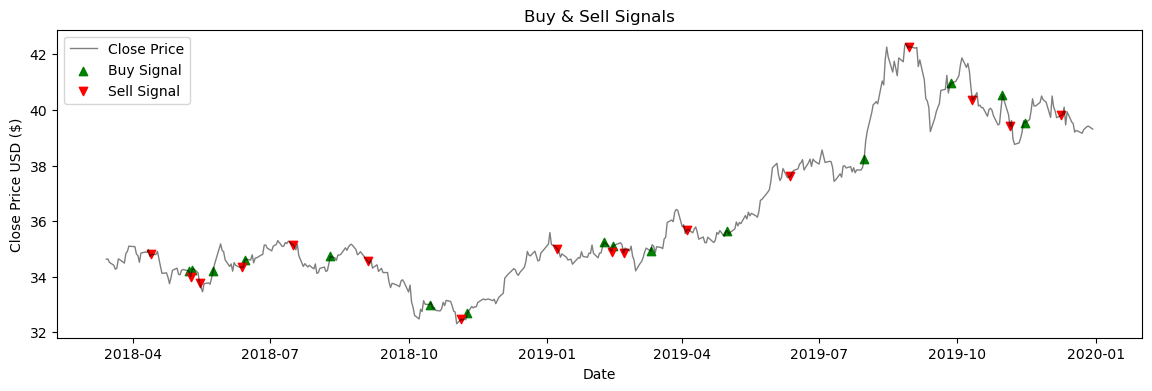

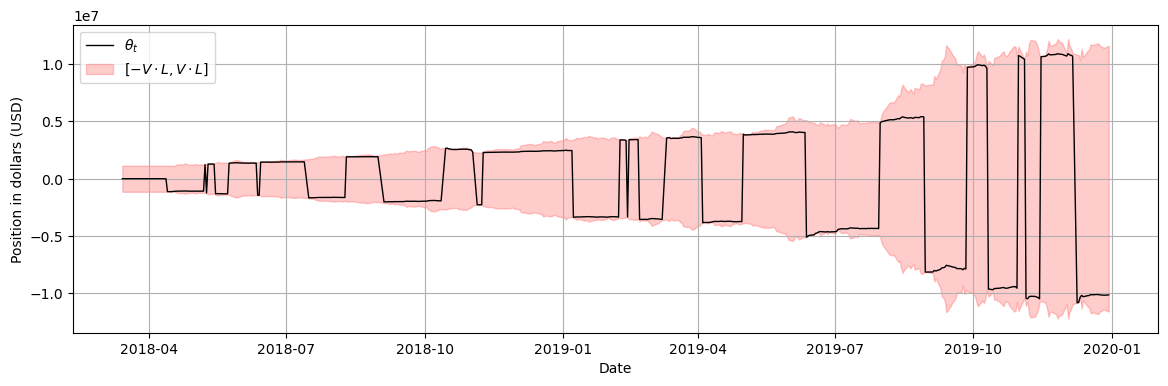

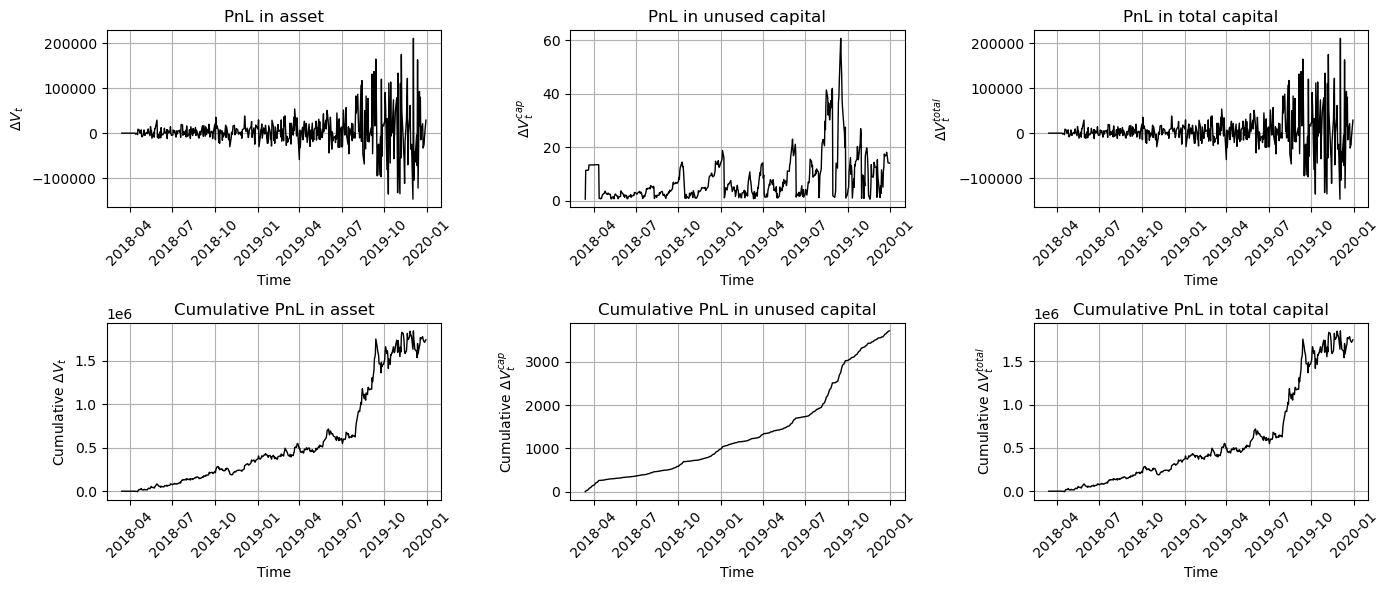

In [665]:
# Testing set performance
result_test = compute_position_value(df = test_set, 
                           signal = regime_test, 
                           initial_capital = INITIAL_CAP, 
                           max_leverage = LEVERAGE, 
                           reduced_leverage_shorting = False,
                           hold_at_signal_0 = True)

plot_strategy(df = test_set, 
              result_dict = result_test, 
              signal = regime_test, 
              leverage = MAX_LEVERAGE)

In [666]:
df_train_res = pd.DataFrame(result_train)
df_train_res['Date'] = np.array(train_set['Date'])
df_train_res['Close'] = np.array(train_set['Close'])
df_train_res['Signal'] = regime_train


df_test_res = pd.DataFrame(result_test)
df_test_res['Date'] = np.array(test_set['Date'])
df_test_res['Close'] = np.array(test_set['Close'])
df_test_res['Signal'] = regime_test


if INCREASE_RF:
    df_train_res.to_csv('models_data/MACD_TRAIN_RF.csv')
    df_test_res.to_csv('models_data/MACD_TEST_RF.csv')
else:
    df_train_res.to_csv('models_data/MACD_TRAIN.csv')
    df_test_res.to_csv('models_data/MACD_TEST.csv')

## Train-test comparison

Text(0, 0.5, 'MACD')

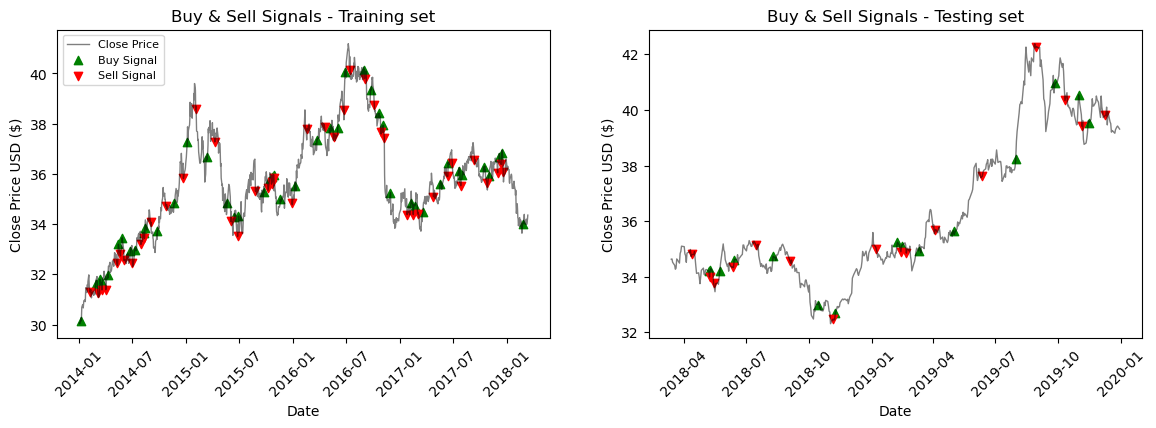

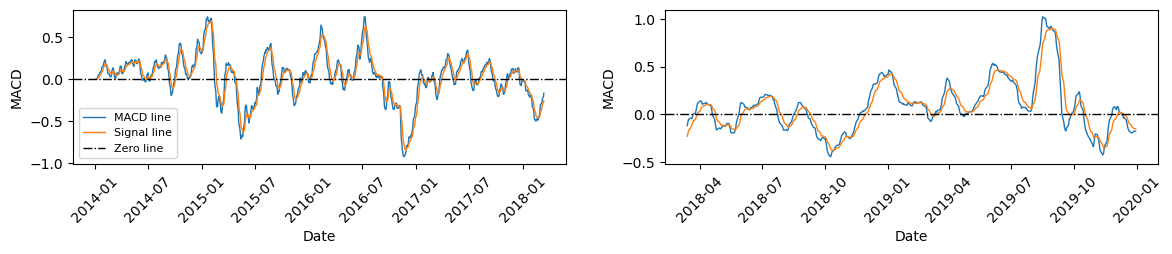

In [667]:
fig, ax = plot_signals_compare(train_data = train_set, 
                     train_signal = regime_train, 
                     test_data = test_set, 
                     test_signal = regime_test)

ax[0].legend(loc = 'upper left', fontsize = 8)
fig, ax = plt.subplots(1, 2, figsize = (14, 2))

ax[0].plot(train_set['Date'], train_set['macd'], lw = 1, label = 'MACD line')
ax[0].plot(train_set['Date'], train_set['macd_signal'], lw = 1, label = 'Signal line')
ax[0].axhline(y = 0, color = 'black', lw = 1, ls = '-.', label = 'Zero line')
ax[0].tick_params(axis = 'x', labelrotation=45)
ax[0].legend(loc = 'lower left', fontsize = 8)
ax[0].set_xlabel('Date')
ax[0].set_ylabel('MACD')

ax[1].plot(test_set['Date'], test_set['macd'], lw = 1, label = 'MACD line')
ax[1].plot(test_set['Date'], test_set['macd_signal'], lw = 1, label = 'Signal line')
ax[1].axhline(y = 0, color = 'black', lw = 1, ls = '-.', label = 'Zero line')
ax[1].tick_params(axis = 'x', labelrotation=45)
ax[1].set_xlabel('Date')
ax[1].set_ylabel('MACD')



/Users/chenkangan/Documents/UCL DSML/Algorithmic Trading/CW2/plotting_computation.py:110: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


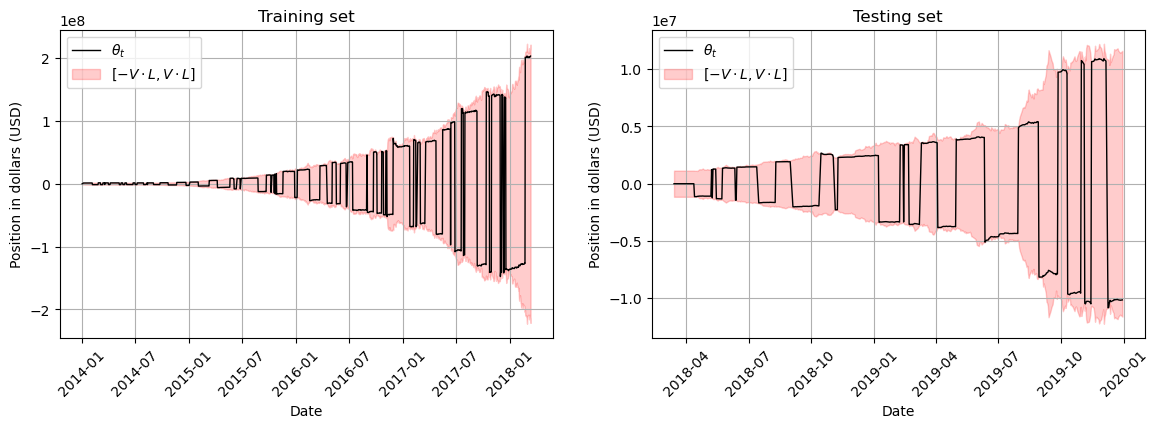

In [668]:
fig, ax = plot_position_compare(train_set_date = train_set['Date'], 
                      train_theta = result_train['theta'], 
                      train_V = result_train['V'], 
                      test_set_date = test_set['Date'], 
                      test_theta = result_test['theta'], 
                      test_V = result_test['V'], 
                      leverage = MAX_LEVERAGE)

/Users/chenkangan/Documents/UCL DSML/Algorithmic Trading/CW2/trading_computation.py:112: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  turnover = [np.sum(np.abs(np.diff(theta[i:i+window_size] / price[i:i+window_size]))) for i in range(len(theta) - window_size + 1)]
/Users/chenkangan/Documents/UCL DSML/Algorithmic Trading/CW2/plotting_computation.py:189: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Text(0.5, 1.0, 'MACD rolling turnover in units')

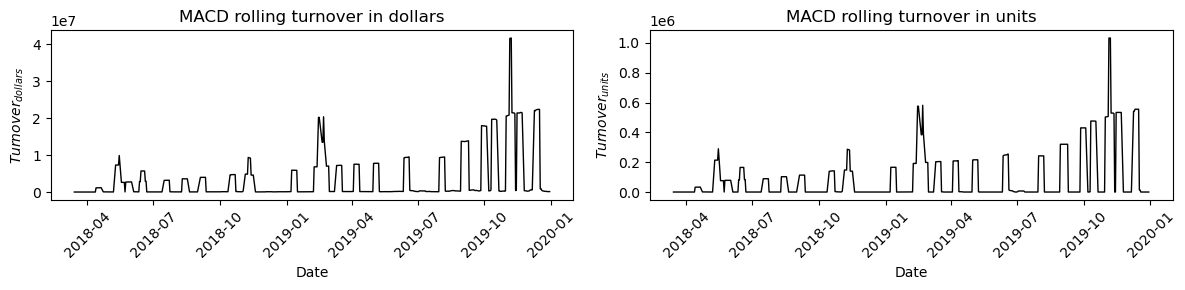

In [669]:
turnover_dollar = calculate_rolling_turnover(theta = result_test['theta'], 
                           price = test_set['Close'], 
                           mode = 'dollar')

turnover_unit = calculate_rolling_turnover(theta = result_test['theta'], 
                           price = test_set['Close'], 
                           mode = 'unit')

    
fig, ax = plot_turnover(test_set, turnover_dollar, turnover_unit, mode = 'Rolling')
ax[0].set_title('MACD rolling turnover in dollars')
ax[1].set_title('MACD rolling turnover in units')

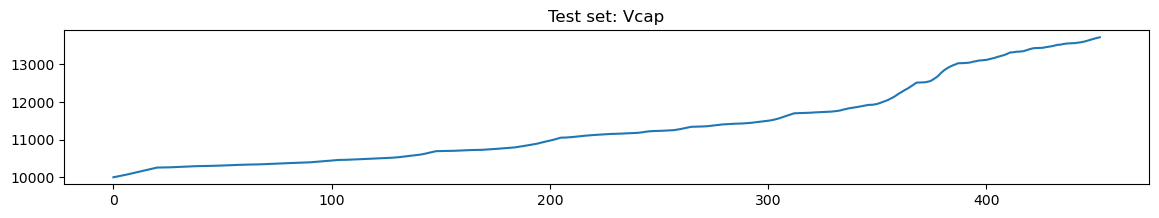

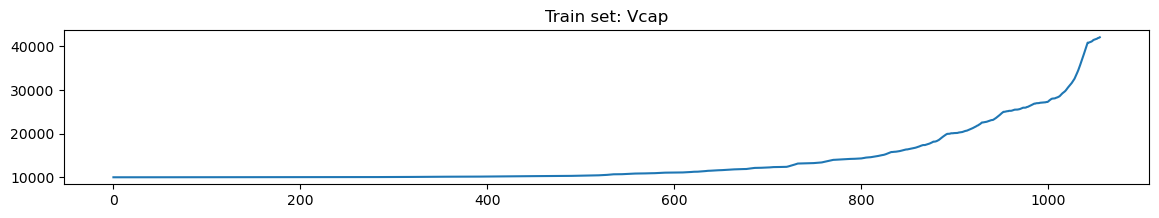

In [670]:
# Check the Vcap
plt.figure(figsize = (14, 2))
plt.title('Test set: Vcap')
plt.plot(result_test['Vcap'])
plt.show()
plt.figure(figsize = (14, 2))
plt.title('Train set: Vcap')
plt.plot(result_train['Vcap'])
plt.show()